#### シンボリック回帰

平衡吸着唐音式の近似式をシンボリック回帰で学習する

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import japanize_matplotlib
from scipy import optimize
import glob
from pprint import pprint
import matplotlib.cm as cm
from sklearn.linear_model import LinearRegression

import sys
sys.path.append("../") # homeディレクトリをpathに追加

---
- データ読み込み

In [2]:
# データ読み込み
df_org = pd.read_excel("../data/20241028_平衡吸着等温式_データセット.xlsm")
df_org = df_org.iloc[1:7, :]

pa = [val.split("kPaA")[0] for val in df_org.iloc[0,1:].values]
# pa = pa[:11]
val1 = np.array([[283]*len(pa), pa, df_org.iloc[1,1:]])
val2 = np.array([[298]*len(pa), pa, df_org.iloc[2,1:]])
val3 = np.array([[313]*len(pa), pa, df_org.iloc[3,1:]])
val4 = np.array([[333]*len(pa), pa, df_org.iloc[4,1:]])
val5 = np.array([[353]*len(pa), pa, df_org.iloc[5,1:]])

df = pd.DataFrame(np.concatenate([val1,val2,val3,val4,val5], 1), index=["T", "P", "adsorp_amt"]).T
df = df.astype("float")

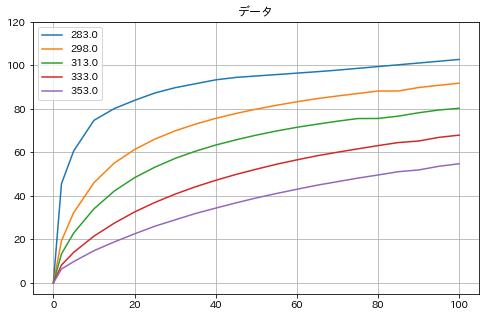

In [3]:
# 可視化
plt.figure(figsize=(8,5))
for i in range(len(df["T"].unique())):
    plt.plot(df["P"].unique(), df.loc[df["T"] == df["T"].unique()[i], "adsorp_amt"], label=df["T"].unique()[i])
plt.legend()
plt.title("データ")
plt.ylim([-5, 120])
plt.grid()
plt.show()

---
- 不足データの線形補間

In [4]:
# 各温度における、圧力ごとの吸着量変化量の線形近似
trend_adsorp = (df.loc[df["T"] == 283.0, "adsorp_amt"].values - df.loc[df["T"] == 353.0, "adsorp_amt"].values) / (353-283)

# 追加データ作成（低温部分）
pred_df = {}
len_P = len(df["P"].unique())
tgt_temp = [273.0, 263.0, 253.0, 243.0]
for temp in tgt_temp:
    pred_list = list(df.loc[df["T"] == 283.0, "adsorp_amt"].values + (283.0 - temp) * trend_adsorp)
    pred_df[temp] = pd.DataFrame([[temp]*len_P, list(df["P"].unique()), pred_list],
                                index=df.columns).T
pred_df = pd.concat([pred_df[temp] for temp in reversed(tgt_temp)])
pred_df = pred_df.reset_index(drop=True)

# 元データに結合
df = pd.concat([pred_df, df]).reset_index(drop=True)

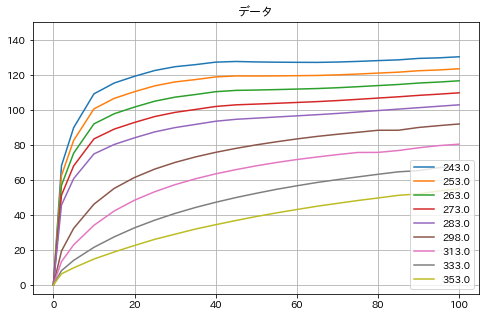

In [5]:
# 可視化
plt.figure(figsize=(8,5))
for i in range(len(df["T"].unique())):
    plt.plot(df["P"].unique(), df.loc[df["T"] == df["T"].unique()[i], "adsorp_amt"], label=df["T"].unique()[i])
plt.legend()
plt.title("データ")
plt.ylim([-5, 150])
plt.grid()
plt.show()

---
- 多項式回帰

In [6]:
### 多項式回帰 1 (べき乗のみ)----------------------------------

# 特徴量作成
df_feature1 = df.copy()
df_feature1["T_P"] = df_feature1["T"] * df_feature1["P"]
df_feature1["T^2"] = df_feature1["T"]**2
df_feature1["P^2"] = df_feature1["P"]**2
df_feature1["T_P^2"] = df_feature1["P^2"] * df_feature1["T"]
df_feature1["T^2_P"] = df_feature1["T^2"] * df_feature1["P"]
df_feature1["T^2_P^2"] = df_feature1["T^2"] * df_feature1["P^2"]

# モデル構築
X1 = df_feature1.drop(columns="adsorp_amt")
y = df_feature1["adsorp_amt"]
model1 = LinearRegression()
model1.fit(X1,y)
df_feature1["pred_poly1"] = model1.predict(X1)

In [7]:
### 多項式回帰 2 (T^-1を追加)----------------------------------

# 特徴量作成
df_feature2 = df.copy()
df_feature2["T_P"] = df_feature2["T"] * df_feature2["P"]

# モデル構築
X2 = df_feature2.drop(columns="adsorp_amt")
y = df_feature2["adsorp_amt"]
model2 = LinearRegression()
model2.fit(X2,y)
df_feature2["pred_poly2"] = model2.predict(X2)

In [8]:
### 多項式回帰 3 (T^-2を追加)----------------------------------

# 特徴量作成
df_feature3 = df.copy()
df_feature3["T_P"] = df_feature3["T"] * df_feature3["P"]

df_feature3["T^2"] = df_feature3["T"]**2
df_feature3["P^2"] = df_feature3["P"]**2
df_feature3["T_P^2"] = df_feature3["P^2"] * df_feature3["T"]
df_feature3["T^2_P"] = df_feature3["T^2"] * df_feature3["P"]
df_feature3["T^2_P^2"] = df_feature3["T^2"] * df_feature3["P^2"]

df_feature3["T-1"] = df_feature3["T"]**(-1)
df_feature3["T-1_P"] = df_feature3["T-1"] * df_feature3["P"]
df_feature3["T-1_P^2"] = df_feature3["T-1"] * df_feature3["P^2"]

df_feature3["T-2"] = df_feature3["T"]**(-2)
df_feature3["T-2_P"] = df_feature3["T-2"] * df_feature3["P"]
df_feature3["T-2_P^2"] = df_feature3["T-2"] * df_feature3["P^2"]

# モデル構築
X3 = df_feature3.drop(columns="adsorp_amt")
y = df_feature3["adsorp_amt"]
model3 = LinearRegression()
model3.fit(X3,y)
df_feature3["pred_poly3"] = model3.predict(X3)

In [9]:
### 多項式回帰 4 (P^(2/5)) ----------------------------------
from sklearn.linear_model import Lasso
# 特徴量作成
df_feature4 = df.copy()
df_feature4["T_P"] = df_feature4["T"] * df_feature4["P"]

df_feature4["P^05"] = df_feature4["P"]**(0.5)
df_feature4["T_P^05"] = df_feature4["T"] * df_feature4["P^05"]

df_feature4["P^04"] = df_feature4["P"]**(0.4)
df_feature4["T_P^04"] = df_feature4["T"] * df_feature4["P^04"]

df_feature4["P^03"] = df_feature4["P"]**(0.3)
df_feature4["T_P^03"] = df_feature4["T"] * df_feature4["P^03"]

df_feature4["P^02"] = df_feature4["P"]**(0.2)
df_feature4["T_P^02"] = df_feature4["T"] * df_feature4["P^02"]

df_feature4["P^01"] = df_feature4["P"]**(0.1)
df_feature4["T_P^01"] = df_feature4["T"] * df_feature4["P^01"]

df_feature4 = df_feature4.drop(columns=["T"])

# モデル構築
X4 = df_feature4.drop(columns="adsorp_amt")
y = df_feature4["adsorp_amt"]
model4 = LinearRegression(fit_intercept=False)
model4.fit(X4,y)
df_feature4["pred_poly4"] = model4.predict(X4)

In [11]:
### 多項式回帰 5 (P^(2/5)) ----------------------------------
from sklearn.linear_model import Lasso
# 特徴量作成
df_feature5 = df.copy()

# モデル構築
X5 = df_feature5.drop(columns="adsorp_amt")
y = df_feature5["adsorp_amt"]
df_feature5["pred_poly5"] = (
    X5["P"]*(252.0724 - 0.50989705*X5["T"])/(X5["P"] - 3554.54819062669*(1 - 0.0655247236249063*np.sqrt(X5["T"]))**3 + 1.7354268)
)

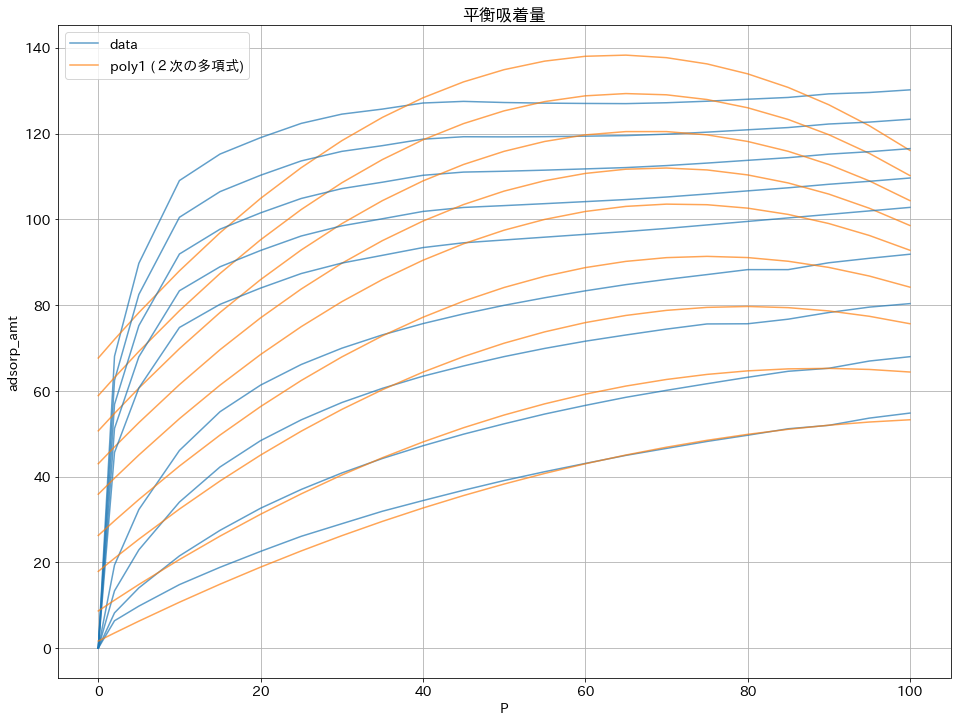

In [16]:
# 可視化
plt.figure(figsize=(16,12))
plt.rcParams["font.size"] = 14

plt.plot(df["P"].unique(), df.loc[df["T"] == df["T"].unique()[0], "adsorp_amt"], color="tab:blue", label="data", alpha=0.7)
plt.plot(df["P"].unique(), df_feature1.loc[df["T"] == df["T"].unique()[0], "pred_poly1"], color="tab:orange", label="poly1 (２次の多項式)", alpha=0.7)
# plt.plot(df["P"].unique(), df_feature2.loc[df["T"] == df["T"].unique()[0], "pred_poly2"], color="tab:green", label="poly2 (2次+-1次の多項式)", alpha=0.7)
# plt.plot(df["P"].unique(), df_feature3.loc[df["T"] == df["T"].unique()[0], "pred_poly3"], color="tab:red", label="poly3 (2次+-2次の多項式)", alpha=0.7)
# plt.plot(df["P"].unique(), df_feature4.loc[df["T"] == df["T"].unique()[0], "pred_poly4"], color="tab:purple", label="poly4 (1/n)", alpha=0.7)
# plt.plot(df["P"].unique(), df_feature5.loc[df["T"] == df["T"].unique()[0], "pred_poly5"], color="tab:purple", label="poly5 (1/n)", alpha=0.7)
for i in range(1,len(df["T"].unique())):
    plt.plot(df["P"].unique(), df.loc[df["T"] == df["T"].unique()[i], "adsorp_amt"], color="tab:blue", alpha=0.7)
    plt.plot(df["P"].unique(), df_feature1.loc[df["T"] == df["T"].unique()[i], "pred_poly1"], color="tab:orange", alpha=0.7)
    # plt.plot(df["P"].unique(), df_feature2.loc[df["T"] == df["T"].unique()[i], "pred_poly2"], color="tab:green", alpha=0.7)
    # plt.plot(df["P"].unique(), df_feature3.loc[df["T"] == df["T"].unique()[i], "pred_poly3"], color="tab:red", alpha=0.7)
    # plt.plot(df["P"].unique(), df_feature4.loc[df["T"] == df["T"].unique()[i], "pred_poly4"], color="tab:purple", alpha=0.7)
    # plt.plot(df["P"].unique(), df_feature5.loc[df["T"] == df["T"].unique()[i], "pred_poly5"], color="tab:purple", alpha=0.7)
plt.legend()
plt.xlabel("P")
plt.ylabel("adsorp_amt")
plt.title("平衡吸着量")
# plt.xlim([-1,50])
plt.grid()
plt.show()

---
- シンボリック回帰

In [42]:
from pysr import PySRRegressor

Detected IPython. Loading juliacall extension. See https://juliapy.github.io/PythonCall.jl/stable/compat/#IPython


In [43]:
### シンボリック回帰 1 --------------------------

model1 = PySRRegressor(
    model_selection="best",  # 最良のモデルを選択
    niterations=5000,        # 反復回数
    binary_operators=["+", "-", "*", "/"],  # 使用する二項演算子
    unary_operators=["square", "cube", 'sqrt', 'log', 'neg', 'inv(x)=1/x'],     # 使用する単項演算子
    elementwise_loss="loss(x, y) = (x - y)^2",  # 損失関数の定義
    extra_sympy_mappings={"inv": lambda x: 1 / x},
    maxsize = 30,
    verbosity=-1,                   # 詳細ログのレベル
    temp_equation_file=False,         # 一時ファイルとバックアップファイルを生成しない
)

X = df.copy().drop(columns="adsorp_amt")
y = df["adsorp_amt"]
model1.fit(X, y)

best_model_equation = model1.sympy()
print(best_model_equation)

c:\Users\jfe144674\WorkSpace\PJ493_DataAssim_CatalyticReactor\.pj493env\lib\site-packages\pysr\sr.py:2582: UserWarning: Note: it looks like you are running in Jupyter. The progress bar will be turned off.
  warnings.warn(


Compiling Julia backend...
0.5311708*sqrt(P/(P + 1.54710326563338e-21*T**9))*(491.82608 - T)


In [62]:
### シンボリック回帰 2 (inv2)--------------------------

model2 = PySRRegressor(
    model_selection="best",  # 最良のモデルを選択
    niterations=10000,        # 反復回数
    binary_operators=["+", "-", "*", "/"],  # 使用する二項演算子
    unary_operators=["square", "cube", 'sqrt', 'log', 'neg', 'inv(x)=1/x'],     # 使用する単項演算子
    elementwise_loss="loss(x, y) = (x - y)^2",  # 損失関数の定義
    extra_sympy_mappings={"inv": lambda x: 1 / x},
    maxsize = 20,
    verbosity=-1,                   # 詳細ログのレベル
    temp_equation_file=False,         # 一時ファイルとバックアップファイルを生成しない
)

X = df.copy().drop(columns="adsorp_amt")
y = df["adsorp_amt"]
model2.fit(X, y)

best_model_equation = model2.sympy()
print(best_model_equation)

c:\Users\jfe144674\WorkSpace\PJ493_DataAssim_CatalyticReactor\.pj493env\lib\site-packages\pysr\sr.py:2582: UserWarning: Note: it looks like you are running in Jupyter. The progress bar will be turned off.
  warnings.warn(


P*(252.0724 - 0.50989705*T)/(P - 3554.54819062669*(1 - 0.0655247236249063*sqrt(T))**3 + 1.7354268)


In [63]:
### シンボリック回帰 3 (inv2) -------------------------

model3 = PySRRegressor(
    model_selection="best",  # 最良のモデルを選択
    niterations=10000,        # 反復回数
    binary_operators=["+", "-", "*", "/"],  # 使用する二項演算子
    unary_operators=["square", "cube", 'sqrt', 'log', 'neg', 'inv(x)=1/x'],     # 使用する単項演算子
    elementwise_loss="loss(x, y) = (x - y)^2",  # 損失関数の定義
    extra_sympy_mappings={"inv": lambda x: 1 / x},
    maxsize = 40,
    verbosity=-1,                   # 詳細ログのレベル
    temp_equation_file=False,         # 一時ファイルとバックアップファイルを生成しない
)

X = df.copy().drop(columns="adsorp_amt")
y = df["adsorp_amt"]
model3.fit(X, y)

best_model_equation = model3.sympy()
print(best_model_equation)

c:\Users\jfe144674\WorkSpace\PJ493_DataAssim_CatalyticReactor\.pj493env\lib\site-packages\pysr\sr.py:2582: UserWarning: Note: it looks like you are running in Jupyter. The progress bar will be turned off.
  warnings.warn(


(-T + log((P**3 - (P**2 - 1.867179)/log(120064.093387076/T**2))**6) + 328.55292)/(1.2330861 + (P + 0.15224999)**(-3))


In [64]:
### score計算 ------------------------------
from sklearn.metrics import mean_squared_error
score1 = mean_squared_error(df["adsorp_amt"], model1.predict(X), squared=True)
score2 = mean_squared_error(df["adsorp_amt"], model2.predict(X), squared=True)
score3 = mean_squared_error(df["adsorp_amt"], model3.predict(X), squared=True)
print("RMSEscore_symb1: ", score1)
print("RMSEscore_symb2: ", score2)
print("RMSEscore_symb3: ", score3)

RMSEscore_symb1:  9.183202952383144
RMSEscore_symb2:  8.031776090861111
RMSEscore_symb3:  13.820724020676323


In [114]:
### 可視化 (高温部) ------------------------------------

df_tmp = df.copy()
df_tmp["pred_symb_1"] = model1.predict(X)
df_tmp["pred_symb_2"] = model2.predict(X)
df_tmp["pred_symb_3"] = model3.predict(X)

label1 = f"symb1_{model1.sympy()}"
label2 = f"symb2_{model2.sympy()}"
label3 = f"symb3_{model3.sympy()}"

plt.figure(figsize=(20,12))
plt.rcParams["font.size"] = 14
plt.plot(df["P"].unique(), df.loc[df["T"] == df["T"].unique()[0], "adsorp_amt"], color="black", label="data", alpha=0.7)
# plt.plot(df["P"].unique(), df_tmp.loc[df["T"] == df["T"].unique()[0], "pred_symb_1"], color="tab:blue", label=label1, alpha=0.7)
plt.plot(df["P"].unique(), df_tmp.loc[df["T"] == df["T"].unique()[0], "pred_symb_2"], color="tab:orange", label=label2, alpha=0.7)
# plt.plot(df["P"].unique(), df_tmp.loc[df["T"] == df["T"].unique()[0], "pred_symb_3"], color="tab:green", label=label3, alpha=0.7)
for temp in df["T"].unique()[4:]:
    plt.plot(df["P"].unique(), df.loc[df["T"] == temp, "adsorp_amt"], color="black", alpha=0.7)
    # plt.plot(df["P"].unique(), df_tmp.loc[df["T"] == temp, "pred_symb_1"], color="tab:blue", alpha=0.7)
    plt.plot(df["P"].unique(), df_tmp.loc[df["T"] == temp, "pred_symb_2"], color="tab:orange", alpha=0.7)
    # plt.plot(df["P"].unique(), df_tmp.loc[df["T"] == temp, "pred_symb_3"], color="tab:green", alpha=0.7)
plt.legend()
plt.xlabel("P")
plt.ylabel("adsorp_amt")
plt.title("平衡吸着量")
plt.xlim([-1,100])
plt.grid()
plt.show()

<Figure size 1440x864 with 0 Axes>

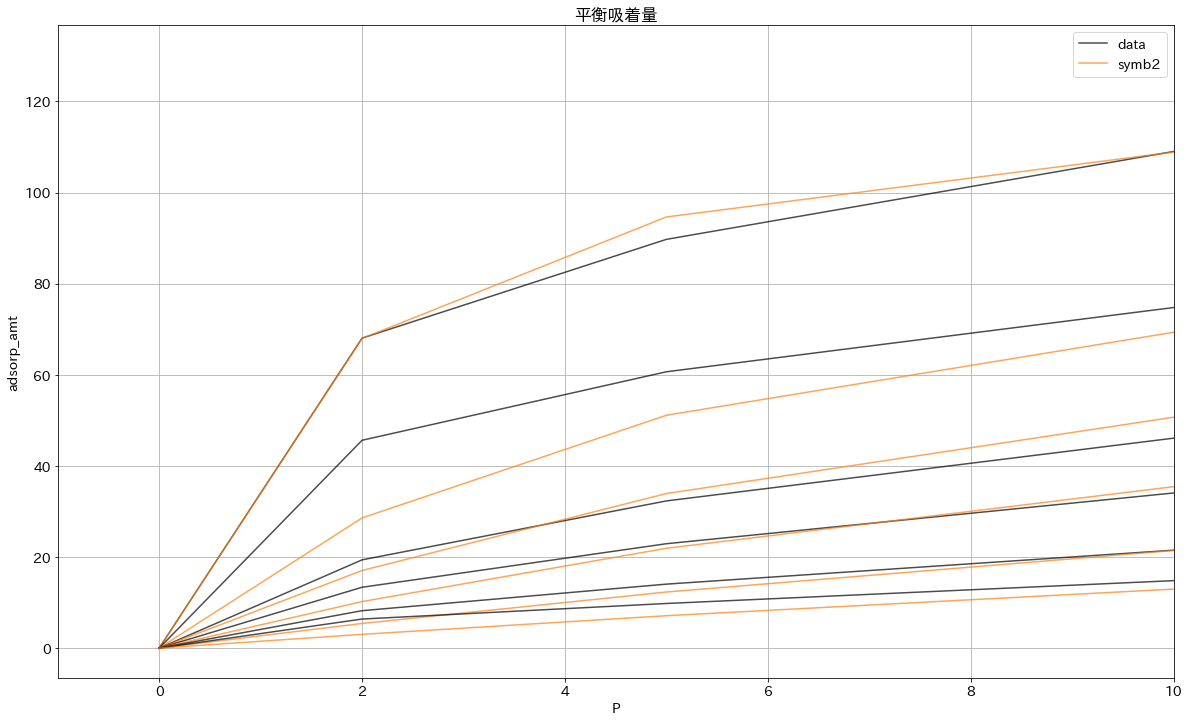

In [110]:
### 可視化 (低温部) ------------------------------------

df_tmp = df.copy()
df_tmp["pred_symb_1"] = model1.predict(X)
df_tmp["pred_symb_2"] = model2.predict(X)
df_tmp["pred_symb_3"] = model3.predict(X)

plt.figure(figsize=(20,12))
plt.rcParams["font.size"] = 14

label1 = "symb1"
label2 = "symb2"
label3 = "symb3"

plt.figure(figsize=(20,12))
plt.rcParams["font.size"] = 14

plt.plot(df["P"].unique(), df.loc[df["T"] == df["T"].unique()[0], "adsorp_amt"], color="black", label="data", alpha=0.7)
# plt.plot(df["P"].unique(), df_tmp.loc[df["T"] == df["T"].unique()[0], "pred_symb_1"], color="tab:blue", label=label1, alpha=0.7)
plt.plot(df["P"].unique(), df_tmp.loc[df["T"] == df["T"].unique()[0], "pred_symb_2"], color="tab:orange", label=label2, alpha=0.7)
# plt.plot(df["P"].unique(), df_tmp.loc[df["T"] == df["T"].unique()[0], "pred_symb_3"], color="tab:green", label=label3, alpha=0.7)
for temp in df["T"].unique()[4:]:
    plt.plot(df["P"].unique(), df.loc[df["T"] == temp, "adsorp_amt"], color="black", alpha=0.7)
    # plt.plot(df["P"].unique(), df_tmp.loc[df["T"] == temp, "pred_symb_1"], color="tab:blue", alpha=0.7)
    plt.plot(df["P"].unique(), df_tmp.loc[df["T"] == temp, "pred_symb_2"], color="tab:orange", alpha=0.7)
    # plt.plot(df["P"].unique(), df_tmp.loc[df["T"] == temp, "pred_symb_3"], color="tab:green", alpha=0.7)
plt.legend()
plt.xlabel("P")
plt.ylabel("adsorp_amt")
plt.title("平衡吸着量")
plt.xlim([-1,10])
plt.grid()
plt.show()

---
- 妥当性検証

In [121]:
T = np.arange(203,413,5)
P = np.arange(0,200,2)
# 温度
T_list = np.array([])
for temp in T:
    T_list = np.append(T_list, np.array([temp]*len(P)))
# 圧力
P_list = np.array([])
for _ in T:
    P_list = np.append(P_list, P)
# データフレーム化
df_test = pd.DataFrame()
df_test["T"] = T_list
df_test["P"] = P_list
df_test["pred_absorb_amt"] = model2.predict(df_test[["T", "P"]])

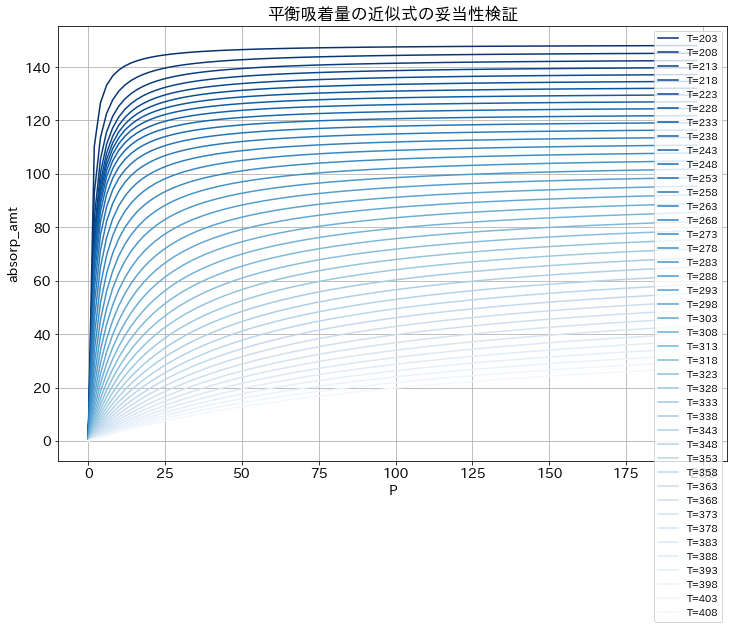

In [122]:
import matplotlib.cm as cm
plt.figure(figsize=(12,8))
for i, temp in enumerate(T):
    plt.plot(P, df_test.loc[df_test["T"] == temp, "pred_absorb_amt"],
            color=cm.Blues_r(i/len(T)),
            label=f"T={temp}")
plt.legend(fontsize=10)
plt.grid()
plt.ylabel("absorp_amt")
plt.xlabel("P")
plt.title("平衡吸着量の近似式の妥当性検証")
plt.show()
# plt.ylim([0,200])